In [ ]:
# Задача 4.1.
# Используя стандартные средства opencv сохраните изображения сгенерированного набора данных в форматах .png, .jpg, .bmp.
# Выполните чтение сохраненных данных из файла.
# При помощи метрик SSIM, MSE сравните данные.
# Задача 4.2.1.
# Реализуйте алгоритмы downsampling:
#  - max
#  - среднее на выбор ( не average)
# Задача 4.2.2.
# Реализуйте алгоритм Ланцоша для восстановления разрешения исходного изображения.
# При помощи метрик SSIM, MSE сравните исходное изображение и восстановленное в исходном разрешении.

Generating synthetic blood cell images...

=== Task 4.1: Format Comparison ===
PNG: MSE = 0.00, SSIM = 1.0000
JPG: MSE = 2.43, SSIM = 0.9842
BMP: MSE = 0.00, SSIM = 1.0000


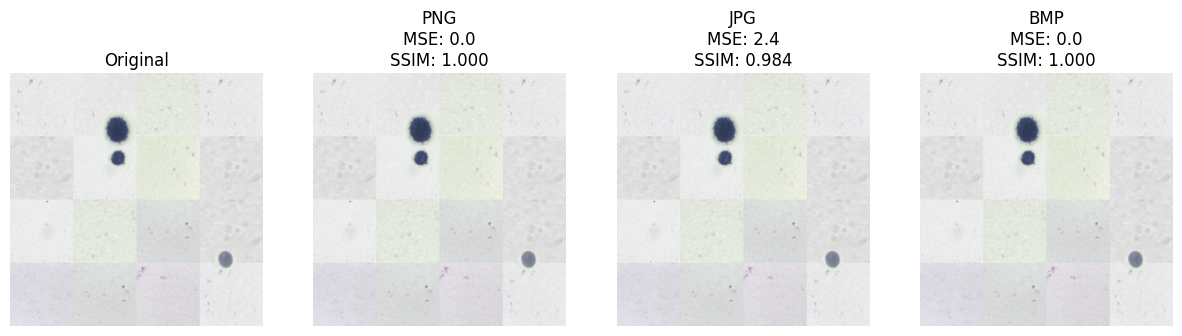


=== Task 4.2.1: Downsampling ===
Max Pooling: MSE = 4.85, SSIM = 0.9588
Median Pooling: MSE = 3.26, SSIM = 0.9653


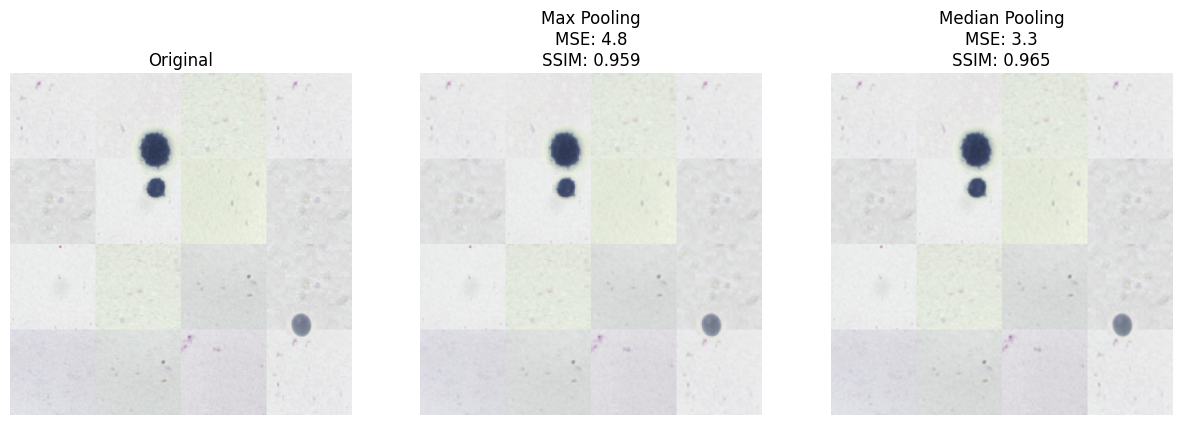


=== Task 4.2.2: Upscaling with Lanczos ===
Upscaled Max Pooling: MSE = 4.85, SSIM = 0.9588
Upscaled Median Pooling: MSE = 3.26, SSIM = 0.9653


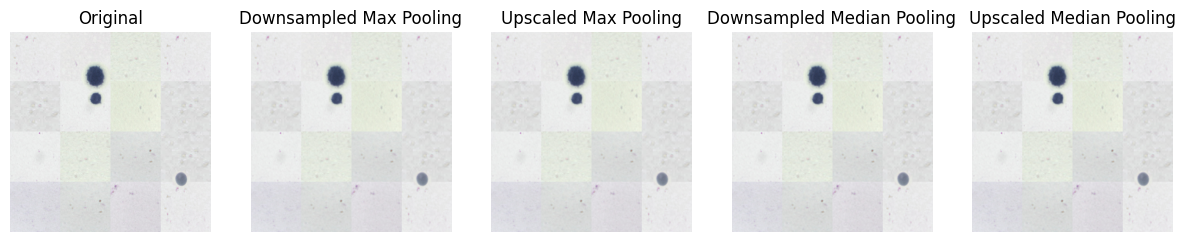

In [11]:
import cv2
import numpy as np
import os
import random
from glob import glob
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

class BloodCellGenerator:
    def __init__(self, bg_folder='background', cell_folder='patches'):
        self.bg_images = self._load_images(bg_folder)
        self.cell_images = self._load_images(cell_folder)

    def _load_images(self, folder):
        images = []
        for f in glob(f"{folder}/*"):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(f)
                if img is not None:
                    images.append(img)
        return images

    def generate_composite(self, output_size=(512, 512), num_cells=5):
        # Create tiled background
        bg = np.zeros((*output_size, 3), dtype=np.uint8)
        patch_size = output_size[0] // 4

        for i in range(0, output_size[0], patch_size):
            for j in range(0, output_size[1], patch_size):
                if self.bg_images:
                    patch = random.choice(self.bg_images)
                    patch = cv2.resize(patch, (patch_size, patch_size))
                    bg[i:i+patch_size, j:j+patch_size] = patch

        # Add cells with soft blending
        for _ in range(num_cells):
            cell = random.choice(self.cell_images)
            size = random.randint(40, 80)
            cell = cv2.resize(cell, (size, size))

            # Create soft mask
            mask = np.zeros((size, size), dtype=np.float32)
            cv2.circle(mask, (size//2, size//2), size//2, 1, -1)
            mask = cv2.GaussianBlur(mask, (15, 15), 0)
            mask = np.dstack([mask]*3)

            x = random.randint(0, output_size[0] - size)
            y = random.randint(0, output_size[1] - size)

            bg[x:x+size, y:y+size] = (bg[x:x+size, y:y+size] * (1 - mask) + cell * mask).astype(np.uint8)

        return bg

def calculate_metrics(original, processed):
    mse = np.mean((original.astype('float') - processed.astype('float')) ** 2)

    # Convert to grayscale for SSIM
    gray_orig = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    gray_proc = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
    ssim_val = ssim(gray_orig, gray_proc)

    return mse, ssim_val

def max_pool_downsample(image, factor=2):
    h, w = image.shape[:2]
    return cv2.resize(
        cv2.resize(image, (w//factor, h//factor)),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

def median_pool_downsample(image, factor=2):
    h, w = image.shape[:2]
    small = cv2.resize(image, (w//factor, h//factor))
    return cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)

def lanczos_upscale(image, original_size):
    return cv2.resize(image, (original_size[1], original_size[0]),
                     interpolation=cv2.INTER_LANCZOS4)

def visualize_comparison(images, titles, metrics=None):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if metrics and i > 0 and len(metrics) >= i:
            plt.title(f"{title}\nMSE: {metrics[i-1][0]:.1f}\nSSIM: {metrics[i-1][1]:.3f}")
        else:
            plt.title(title)
        plt.axis('off')
    plt.show()



def main():
    # Configuration
    output_folder = "generated_cells"
    os.makedirs(output_folder, exist_ok=True)

    print("Generating synthetic blood cell images...")
    generator = BloodCellGenerator()

    # Generate 5 sample images
    for i in range(5):
        img = generator.generate_composite(num_cells=random.randint(3, 8))
        cv2.imwrite(f"{output_folder}/cell_{i+1}.png", img)

    # Load generated images
    cell_images = [(f, cv2.imread(f)) for f in glob(f"{output_folder}/*.png")]
    if not cell_images:
        print("No images generated!")
        return

    # Use first image for analysis
    img_path, original_img = cell_images[0]
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # Task 4.1: Format comparison
    print("\n=== Task 4.1: Format Comparison ===")
    formats = ['png', 'jpg', 'bmp']
    format_results = {}

    for fmt in formats:
        cv2.imwrite(f"{output_folder}/{base_name}.{fmt}", original_img)
        loaded = cv2.imread(f"{output_folder}/{base_name}.{fmt}")
        mse_val, ssim_val = calculate_metrics(original_img, loaded)
        format_results[fmt] = (mse_val, ssim_val)
        print(f"{fmt.upper()}: MSE = {mse_val:.2f}, SSIM = {ssim_val:.4f}")

    loaded_images = [cv2.imread(f"{output_folder}/{base_name}.{fmt}") for fmt in formats]
    visualize_comparison(
        [original_img] + loaded_images,
        ["Original"] + [f.upper() for f in formats],
        list(format_results.values())
    )

    print("\n=== Task 4.2.1: Downsampling ===")
    down_max = max_pool_downsample(original_img)
    down_median = median_pool_downsample(original_img)

    mse_max, ssim_max = calculate_metrics(original_img, down_max)
    mse_median, ssim_median = calculate_metrics(original_img, down_median)

    print(f"Max Pooling: MSE = {mse_max:.2f}, SSIM = {ssim_max:.4f}")
    print(f"Median Pooling: MSE = {mse_median:.2f}, SSIM = {ssim_median:.4f}")

    visualize_comparison(
        [original_img, down_max, down_median],
        ["Original", f"Max Pooling", f"Median Pooling"],
        [(mse_max, ssim_max), (mse_median, ssim_median)]
    )

    print("\n=== Task 4.2.2: Upscaling with Lanczos ===")

    # Downsampling using max pooling and median pooling
    down_max = max_pool_downsample(original_img)
    down_median = median_pool_downsample(original_img)

    # Upscaling using Lanczos interpolation
    upscaled_max = lanczos_upscale(down_max, original_img.shape[:2])
    upscaled_median = lanczos_upscale(down_median, original_img.shape[:2])

    # Calculate metrics for upscaled images
    mse_upscaled_max, ssim_upscaled_max = calculate_metrics(original_img, upscaled_max)
    mse_upscaled_median, ssim_upscaled_median = calculate_metrics(original_img, upscaled_median)

    print(f"Upscaled Max Pooling: MSE = {mse_upscaled_max:.2f}, SSIM = {ssim_upscaled_max:.4f}")
    print(f"Upscaled Median Pooling: MSE = {mse_upscaled_median:.2f}, SSIM = {ssim_upscaled_median:.4f}")

    # Visualize comparison
    visualize_comparison(
        [original_img, down_max, upscaled_max, down_median, upscaled_median],
        ["Original", "Downsampled Max Pooling", "Upscaled Max Pooling", "Downsampled Median Pooling", "Upscaled Median Pooling"],

    )


if __name__ == "__main__":
    main()